In [1]:
# FUNCTIONSpiup
from PIL import Image
import tensorflow as tf
import numpy as np
import os
import matplotlib as plt
import matplotlib.pyplot as plt2

def saveImages(data, path,epoch = ""):
    i = 0
    add = ""

    for array in data:
        if len(array.shape) == 2:
                array2 = np.asarray(array*255 , np.uint8)
                array2 = np.reshape(array2,[imwidth,imwidth])
                add = "x"+str(epoch).zfill(3)
                im = Image.fromarray(array2)
                im.save(os.path.join(path,add+str(i)+".png"))
                i = i+1
        if len(array.shape)==3:
            if array.shape[2] == 1:
                array = array[:, :, 0]
                add = "z"

            im = Image.fromarray(array)
            im.save(os.path.join(path,add+str(i)+".png"))
            i = i+1

def read_images(input_paths,label_paths):
    """ read filepaths and return decoded images """
    input_content = tf.io.read_file(input_paths)
    label_content = tf.io.read_file(label_paths)
    input_images = tf.image.decode_png(input_content, channels=3)
    labels = tf.image.decode_png(label_content, channels=1)
    return input_images, labels

def create_stars_data(input_image, label):
    """ manipulates images as needed for the stars (and similar) dataset """
    input_image = tf.divide(input_image, np.uint8(255), name="normalize_x")
    input_image = tf.image.resize(input_image, [imwidth, imwidth])
    #input_image = tf.reshape(input_image,[3,imwidth,imwidth])

    label = tf.divide(label, np.uint8(255), name="normalize_y")
    label = tf.image.resize(label, [imwidth, imwidth])
    label = tf.round(label, name="round_y")
    # label = tf.reshape(label,[1,imwidth*imwidth])
    return input_image, label

def showImagesDataColor(data):
            fig=plt2.figure(figsize=(16, 16))
            columns = len(data)
            rows = 1
            i=0
            for array in data:
                i = i+1
                array2 = np.asarray(array*255 , np.uint8)
                #array2 = np.reshape(array2,[imwidth,imwidth,3])
                array2 = np.reshape(array2,[imwidth,imwidth,3])

                fig.add_subplot(rows, columns,i)
                plt2.imshow(array2) #,cmap='sRGB1')
            plt2.show()

def showImagesDataGrey(data):
            fig=plt2.figure(figsize=(16, 16))
            columns = len(data)
            rows = 1
            i=0
            for array in data:
                i = i+1
                array2 = np.asarray(array*255 , np.uint8)
                array2 = np.reshape(array2,[imwidth,imwidth])

                fig.add_subplot(rows, columns,i)
                plt2.imshow(array2,cmap='gray')
            plt2.show()

In [2]:
# import zipfile
# import os

# zip_path = "Stars.zip"  # Replace with the path to your zip file
# extract_path = "extracted_folder"  # Folder where files will be extracted

# # Ensure the extraction folder exists
# os.makedirs(extract_path, exist_ok=True)

# # Unzip the file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

.ZI# ConvStarNet - Visualizing Weights and Activation Maps

In this session, we revisit the star identification task seen earlier where we will use CNNs instead of Dense layers. The notebook therefore follows the same structure as the earlier notebook.


Input:
![2018-11-19_19h52_19.png](attachment:2018-11-19_19h52_19.png)
Output:
![image.png](attachment:image.png)

Our neural network should take some image data x and output some image data y with the recognized stars. For training the network we use the star dataset given with this lecture

![2018-12-18_09h33_42.png](attachment:2018-12-18_09h33_42.png)

## We have to import some libraries and functions first.
Needed libraries are:
pillow, tensorflow, numpy, matplotlib.

In [3]:
import os, platform, sys, glob, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

We first set up some general hyperparameters for the training and preprocessing of the data.

In [4]:
###### Hyperparameter
learnrate = 0.0001    # Learning Rate
batchsize = 10        # Images per batch
ep_lim = 100           # Max number of epochs
imwidth = 25          # Image dimension used for training, smaller images computer faster
                      # big impact on computation time, original image is 75x75
imwidth = imwidth # Set width for imf (image functions)


## Input data
We search the folders containing the data and create two file list, one containing the x and one containing the y file paths


In [5]:
#### Lisiting all Image files
x_path = "extracted_folder/Stars/x"
y_path = "extracted_folder\Stars\y"
file_list_x = []
file_list_y = []
file_list_x += sorted(glob.glob(x_path + "/**/*.png", recursive=True))
file_list_y += sorted(glob.glob(y_path + "/**/*.png", recursive=True))
print("Found ",len(file_list_x)," images")
assert len(file_list_x) == 2350 # If this line failes you did something wrong

Found  2350  images


## Tensorflow Data Pipeline

In [6]:
XX = []
YY = []
for i in range(len(file_list_x)):
    file_x = file_list_x[i]
    file_y = file_list_y[i]
    X,Y = read_images(file_x,file_y)
    X,Y = create_stars_data(X,Y)
    XX.append(X.numpy())
    YY.append(Y.numpy())
XX = np.array(XX)
YY = np.array(YY)
XX = np.reshape(XX, (-1,25,25,3))
YY = np.reshape(YY, (-1,25,25,1))
print(XX.shape)
print(YY.shape)

(2350, 25, 25, 3)
(2350, 25, 25, 1)


## Defining our Neural Network and initial values for all Variables
Now we can define our neural network. This time, we did not need to reshape our figure and can just read them as they are: input is a 2D image with 3 channel, and output is a 2D image with 1 channel.

The dimensions of input tensor x is:

> Add blockquote


![2018-12-18_09h35_51.png](attachment:2018-12-18_09h35_51.png)

The dimensions of our label tensor y_hat is:

![2018-12-18_09h36_21.png](attachment:2018-12-18_09h36_21.png)



Since we have our x,y_hat data we can do whatever we want, as long as the input and output dimensions match the datasets dimensions

### Layer Definitions:
Use the Conv2D layer in tensorflow/keras.
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

In [7]:
## Define your network here
model = tf.keras.Sequential()
model.add( tf.keras.layers.Conv2D(10, input_shape=(imwidth,imwidth,3), kernel_size=3,
                                  activation='relu', padding='same', strides=1) )
model.add( tf.keras.layers.Conv2D(20, kernel_size=3,
                                  activation='relu', padding='same', strides=1) )
model.add( tf.keras.layers.Conv2D(1, kernel_size=3,
                                  activation='sigmoid', padding='same', strides=1) )
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 10)        280       
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 20)        1820      
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 1)         181       
                                                                 
Total params: 2,281
Trainable params: 2,281
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 10)        280       
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 20)       

## Training the Network
We use the difference between the network output and the real image to calculate or cost/loss function. As an optimizier we choose the AdamOptimizer and tell it which function value to minimize

In [1]:
## Need to be filled
# train your network
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
hist = model.fit(XX,YY, batch_size=batchsize, epochs=ep_lim, validation_split=0.2, callbacks=[early_stop_callback])

In [9]:
# Monitor the loss function
loss_history = hist.history['loss']
val_history = hist.history['val_loss']
%matplotlib inline
plt.plot(loss_history)
plt.plot(val_history,'r')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


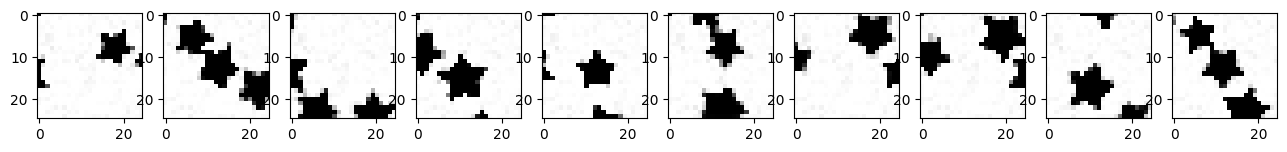

In [ ]:
# check the prediction of a random sample
# use the imf.showImageDataGrey and imf.showImageDataColor to see
# the input/output image
y_nn = model.predict(XX[0:10,:,:])
showImagesDataGrey(y_nn)

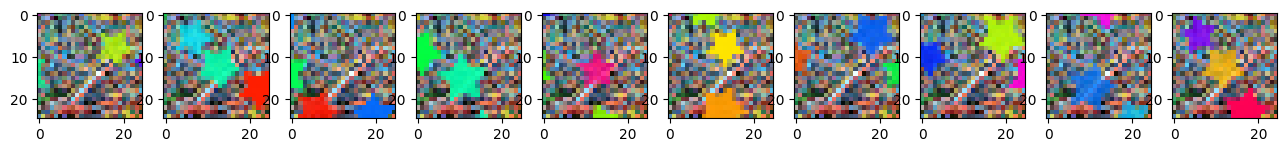

In [ ]:
showImagesDataColor(XX[0:10,:,:])